# Homework 4

In [1]:
# importing the required packages
import datetime
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import numpy as np
import dask
from dask.distributed import performance_report, Client, progress
import pandas as pd

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from eofs.xarray import Eof
from eofs.examples import example_data_path

In [2]:
client = Client()  # set up local cluster on your laptop
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 15.83 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51558,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 15.83 GiB
Comm: tcp://127.0.0.1:51596,Total threads: 2
Dashboard: http://127.0.0.1:51597/status,Memory: 3.96 GiB
Nanny: tcp://127.0.0.1:51562,


# Part 1

In [3]:
# Creating the list of urls for loading the SSTK and TP data.

baseurl_sstk = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/' 
baseurl_2_sstk = '/e5.moda.an.sfc.128_034_sstk.ll025sc.'

baseurl_tp = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/'
baseurl_2_tp = '/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.'

sstk_url_list = []
tp_url_list = []

for year in range(1979, 2022):
    sstk_url = baseurl_sstk + str(year) + baseurl_2_sstk + str(year) + '010100_' + str(year) + '120100.nc'
    tp_url = baseurl_tp + str(year) + baseurl_2_tp + str(year) + '010100_' + str(year) + '120100.nc'

    sstk_url_list.append(sstk_url)
    tp_url_list.append(tp_url)

In [4]:
# loading the data using the url lists created. 
ds_sstk = xr.open_mfdataset(sstk_url_list,  parallel=True).sel(latitude = slice(65,-65), longitude = slice(120, 240))
ds_tp = xr.open_mfdataset(tp_url_list,  parallel=True).sel(latitude = slice(65,-65), longitude = slice(120, 240))

In [5]:
#slicing data to one degree 

lat_new = np.linspace(65, -65, 131)
lon_new = np.linspace(120, 240, 121)
ds = xr.Dataset()
ds = ds_sstk.sel(latitude = lat_new, longitude = lon_new, method = 'nearest').compute()
ds['TP'] = ds_tp.TP.sel(latitude = lat_new, longitude = lon_new, method = 'nearest').compute()

In [30]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 131, longitude: 121, time: 516)
Coordinates:
  * latitude   (latitude) float64 65.0 64.0 63.0 62.0 ... -63.0 -64.0 -65.0
  * longitude  (longitude) float64 120.0 121.0 122.0 123.0 ... 238.0 239.0 240.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Data variables:
    utc_date   (time) int32 1979010100 1979020100 ... 2021110100 2021120100
    SSTK       (time, latitude, longitude) float32 nan nan nan ... 272.6 272.7
    TP         (time, latitude, longitude) float32 0.0002079 ... 0.002506
Attributes:
    DATA_SOURCE:                     ECMWF: https://cds.climate.copernicus.eu...
    NETCDF_CONVERSION:               CISL RDA: Conversion from ECMWF GRIB 1 d...
    NETCDF_VERSION:                  4.6.1
    CONVERSION_PLATFORM:             Linux casper02 3.10.0-693.21.1.el7.x86_6...
    CONVERSION_DATE:                 Mon Nov 11 07:46:57 MST 2019
    Conventions:                     CF-1.6
    NETCDF_COMPRESSION:              NCO: Precision-preserving compression to...
    history:                         Mon Nov 11 07:46:58 2019: ncks -4 --ppc ...
    NCO:                             netCDF Operators version 4.7.9 (Homepage...
    DODS_EXTRA.Unlimited_Dimension:  time

In [31]:
#SAVE DATASET TO LOCAL MACHINE (the file has been saved as final_dataset)
ds.to_netcdf('./datasets/final_dataset')

# Part 2

In [32]:
#deseasoning the data by subracting the monthly mean values
ds_monthly_mean = ds.groupby('time.month').mean().compute()
ds_deseason = ds.groupby('time.month') - ds_monthly_mean

In [33]:
ds_deseasoned = ds_deseason.drop('month', dim=None) #dropping the month coordinate
ds_deseasoned #deseasoned dataset

<xarray.Dataset>
Dimensions:    (latitude: 131, longitude: 121, time: 516)
Coordinates:
  * latitude   (latitude) float64 65.0 64.0 63.0 62.0 ... -63.0 -64.0 -65.0
  * longitude  (longitude) float64 120.0 121.0 122.0 123.0 ... 238.0 239.0 240.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Data variables:
    utc_date   (time) float64 -2.1e+07 -2.1e+07 -2.1e+07 ... 2.1e+07 2.1e+07
    SSTK       (time, latitude, longitude) float32 nan nan ... -0.3624 -0.3983
    TP         (time, latitude, longitude) float32 -0.0001511 ... 0.0008903

In [34]:
#detrending the data

def detrend_dim(da, dim, deg=1): #treating a function to detrend
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit


ds_detrend = xr.Dataset()
ds_detrend['SSTK'] = detrend_dim(ds_deseasoned.SSTK, 'time')
ds_detrend['TP'] = detrend_dim(ds_deseasoned.TP, 'time')

In [35]:
#detrended dataset
ds_detrend

<xarray.Dataset>
Dimensions:    (latitude: 131, longitude: 121, time: 516)
Coordinates:
  * latitude   (latitude) float64 65.0 64.0 63.0 62.0 ... -63.0 -64.0 -65.0
  * longitude  (longitude) float64 120.0 121.0 122.0 123.0 ... 238.0 239.0 240.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Data variables:
    SSTK       (time, latitude, longitude) float64 nan nan ... -0.06005 -0.04982
    TP         (time, latitude, longitude) float64 -0.0002469 ... 0.0008413

In [36]:
#standardizing the data 

climatology_mean = ds_detrend.groupby('time.month').mean('time') 
climatology_std = ds_detrend.groupby('time.month').std('time')

ds_stand = xr.apply_ufunc( lambda x, m, s: (x - m) / s,
                            ds_detrend.groupby('time.month'),
                            climatology_mean, climatology_std)

c:\Users\Charu\miniconda3\envs\py3-swn\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Charu\miniconda3\envs\py3-swn\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Charu\miniconda3\envs\py3-swn\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Charu\miniconda3\envs\py3-swn\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Charu\miniconda3\envs\py3-swn\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, d

In [37]:
ds_standard = ds_stand.drop('month', dim=None) #dropping the month coordinate
ds_standard #standardized dataset

<xarray.Dataset>
Dimensions:    (time: 516, latitude: 131, longitude: 121)
Coordinates:
  * latitude   (latitude) float64 65.0 64.0 63.0 62.0 ... -63.0 -64.0 -65.0
  * longitude  (longitude) float64 120.0 121.0 122.0 123.0 ... 238.0 239.0 240.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Data variables:
    SSTK       (time, latitude, longitude) float64 nan nan ... -0.08712 -0.07077
    TP         (time, latitude, longitude) float64 -1.67 -1.3 ... 1.884 1.975

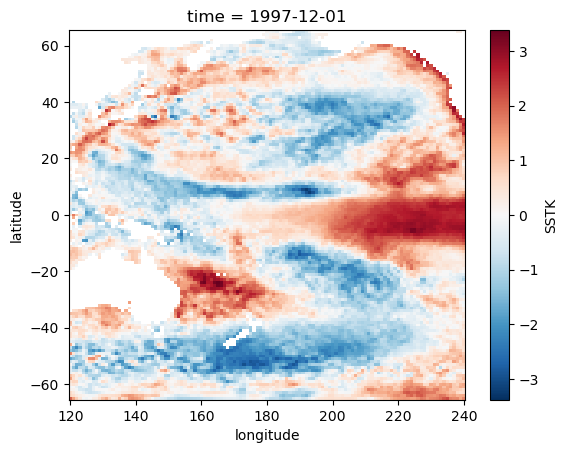

In [38]:
# Just a random plot to see if the dataset is correct!

ds_standard['SSTK'].sel(time='1997-12-01').plot()

# Part 3

Performing an EOF analysis

In [40]:
#perforMing EOF with cosine latitude weighting

coslat = np.cos(np.deg2rad(ds_standard.coords['latitude'].values)) #taking cosine of latitude
wgts = np.sqrt(coslat)[..., np.newaxis] #assigning the weights
solver = Eof(ds_standard.SSTK, weights=wgts) #performing the EOF analysis on the SST anamolies

In [41]:
#retieving the first five principal components
eof = solver.eofsAsCorrelation(neofs=5)  ##THE FIRST 5 EOFS

eof

<xarray.DataArray 'eofs' (mode: 5, latitude: 131, longitude: 121)>
array([[[        nan,         nan,         nan, ...,  0.04406125,
          0.04238738,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.08386516, -0.06083138, -0.04240916, ..., -0.42452973,
         -0.4044342 , -0.38168932],
        [-0.12172518, -0.10055771, -0.08651076, ..., -0.35019157,
         -0.37229193, -0.36676767],
        [-0.05128878, -0.04104905, -0.02002905, ..., -0.30355774,
         -0.30871718, -0.32701189]],

       [[        nan,         nan,         nan, ...,  0.01339103,
          0.00643229,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [ 0.07098673,  0.08621743,  0.08208569, ...,  0.04528592,
          0.04964688,  0.08686805],
        [ 0.02824097,  0.0354794 ,  0.03180096, ...,  0.02368379,
          0.03397497,  0.04830806],
        [-0.0079253 , -0.00713339, -0.01023736, ...,  0.00484992,
          0.00532535,  0.02887536]],

       [[        nan,         nan,         nan, ...,  0.05542874,
          0.06007583,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.02270329, -0.00265571, -0.01658046, ..., -0.08765731,
         -0.11365223, -0.11085486],
        [ 0.05483565,  0.04959158,  0.04721467, ..., -0.12455787,
         -0.10051122, -0.09657853],
        [-0.00907836, -0.01363605, -0.00512972, ..., -0.14813722,
         -0.17251317, -0.1617302 ]]])
Coordinates:
  * mode       (mode) int32 0 1 2 3 4
  * latitude   (latitude) float64 65.0 64.0 63.0 62.0 ... -63.0 -64.0 -65.0
  * longitude  (longitude) float64 120.0 121.0 122.0 123.0 ... 238.0 239.0 240.0
Attributes:
    long_name:  correlation_between_pcs_and_SSTK

Text(0.5, 1.0, 'EOF1 expressed as correlation')

c:\Users\Charu\miniconda3\envs\py3-swn\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


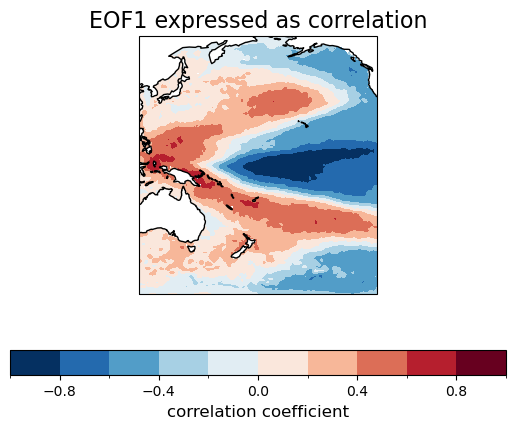

In [42]:
# Plotting the leading EOF expressed as correlation between the principal component
# and input SST anomalies at each grid point.

clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eof[0].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EOF1 expressed as correlation', fontsize=16)


Text(0.5, 1.0, 'EOF2 expressed as correlation')

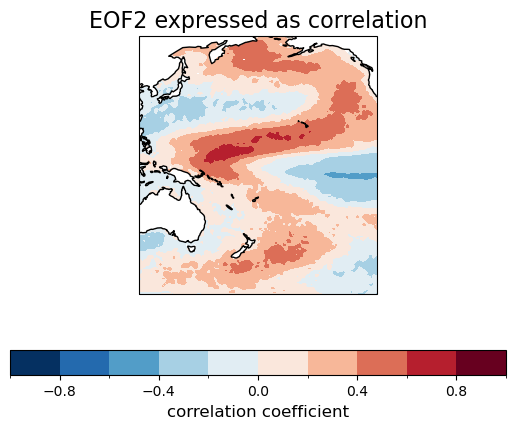

In [43]:
# Plotting the second EOF expressed as correlation between the principal component
# and input SST anomalies at each grid point.

clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eof[1].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EOF2 expressed as correlation', fontsize=16)


Text(0.5, 1.0, 'EOF3 expressed as correlation')

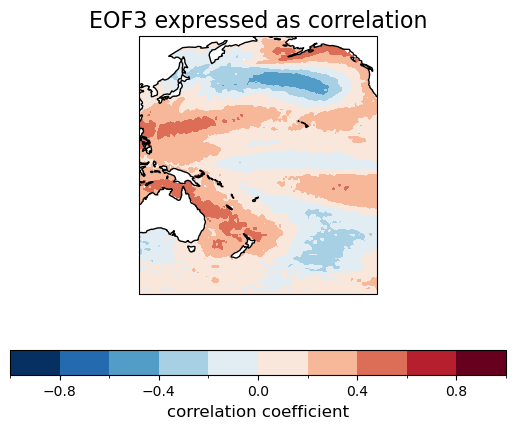

In [44]:
# Plotting the third EOF expressed as correlation between the principal component
# and input SST anomalies at each grid point.

clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eof[2].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EOF3 expressed as correlation', fontsize=16)


Text(0.5, 1.0, 'EOF4 expressed as correlation')

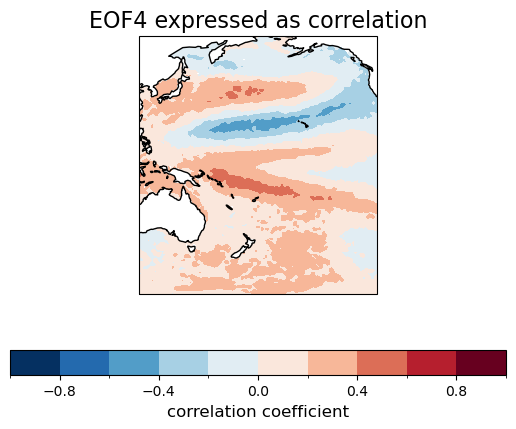

In [45]:
# Plotting the fourth EOF expressed as correlation between the principal component
# and input SST anomalies at each grid point.

clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eof[3].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EOF4 expressed as correlation', fontsize=16)


Text(0.5, 1.0, 'EOF5 expressed as correlation')

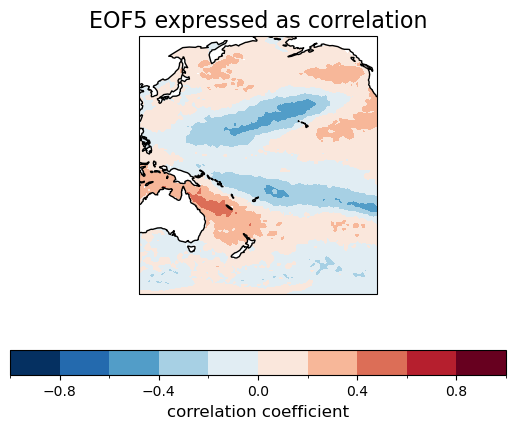

In [46]:
# Plotting the fifth EOF expressed as correlation between the principal component
# and input SST anomalies at each grid point.

clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eof[4].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EOF5 expressed as correlation', fontsize=16)

# Part 4

In [47]:
#extracting the fraction of variance explained by each EOF

varfrac = solver.varianceFraction() * 100 #multiply by 100 to convert fractions to percentage

(3.6586946218589286e-32, 18.70291244270457)

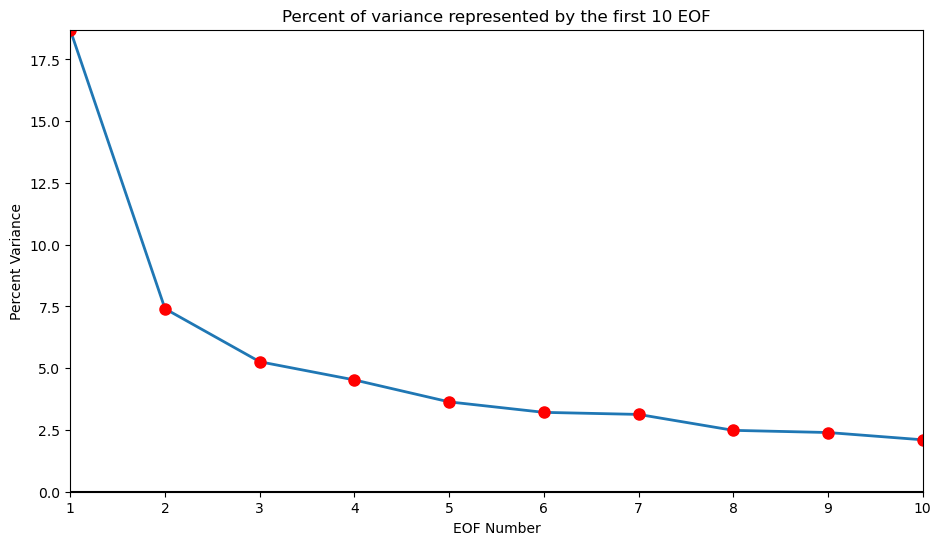

In [48]:
# Plotting the percent of variance explained by the first 10 EOF
plt.figure(figsize=(11,6))
eof_num = range(1, 11)
plt.plot(eof_num, varfrac[0:10], linewidth=2)
plt.plot(eof_num, varfrac[0:10], linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 11))
plt.title('Percent of variance represented by the first 10 EOF')
plt.xlabel('EOF Number')
plt.ylabel('Percent Variance')
plt.xlim(1, 10)
plt.ylim(np.min(varfrac), np.max(varfrac)+0.01)

# Part 5

In [49]:
ds_standard.load()

<xarray.Dataset>
Dimensions:    (time: 516, latitude: 131, longitude: 121)
Coordinates:
  * latitude   (latitude) float64 65.0 64.0 63.0 62.0 ... -63.0 -64.0 -65.0
  * longitude  (longitude) float64 120.0 121.0 122.0 123.0 ... 238.0 239.0 240.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Data variables:
    SSTK       (time, latitude, longitude) float64 nan nan ... -0.08712 -0.07077
    TP         (time, latitude, longitude) float64 -1.67 -1.3 ... 1.884 1.975

In [50]:
#reconstructing the SST field using the first 5 EOFs
ds_restructed = solver.reconstructedField(5)

ds_restructed

<xarray.DataArray 'SSTK' (time: 516, latitude: 131, longitude: 121)>
array([[[        nan,         nan,         nan, ...,  0.03175475,
          0.03071424,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.08487543,  0.13830544,  0.1323883 , ..., -0.03448544,
         -0.00571288, -0.00837671],
        [ 0.00728652,  0.01853533,  0.00475614, ..., -0.08842479,
         -0.07583567, -0.07389904],
        [-0.05406026, -0.06011433, -0.0677677 , ..., -0.13359364,
         -0.14559233, -0.12641001]],

       [[        nan,         nan,         nan, ...,  0.02334966,
          0.03289698,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [-0.08339483, -0.01107189, -0.00837387, ..., -0.69920748,
         -0.70520748, -0.61835224],
        [-0.06958183, -0.03729895, -0.02097041, ..., -0.65618404,
         -0.64499327, -0.61387472],
        [-0.08914378, -0.07818839, -0.03642312, ..., -0.63402041,
         -0.67431594, -0.66090661]],

       [[        nan,         nan,         nan, ...,  0.16742988,
          0.18107171,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.15109645, -0.06309728, -0.05976705, ..., -0.79026748,
         -0.81410796, -0.78226296],
        [-0.06248755, -0.04683476, -0.0400232 , ..., -0.78238468,
         -0.75674902, -0.73532139],
        [-0.10994439, -0.10555817, -0.06392558, ..., -0.78373044,
         -0.83939493, -0.83250848]]])
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
  * latitude   (latitude) float64 65.0 64.0 63.0 62.0 ... -63.0 -64.0 -65.0
  * longitude  (longitude) float64 120.0 121.0 122.0 123.0 ... 238.0 239.0 240.0
Attributes:
    long_name:  SSTK_reconstructed_with_5_EOFs

In [51]:
# finding the correlation between reconstructed and obersved monthly 
# SST time series

correlation = xr.corr(ds_restructed, ds_standard.SSTK, dim = 'time')
correlation

c:\Users\Charu\miniconda3\envs\py3-swn\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Charu\miniconda3\envs\py3-swn\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


<xarray.DataArray 'SSTK' (latitude: 131, longitude: 121)>
array([[       nan,        nan,        nan, ..., 0.09044482, 0.08379104,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.12816137, 0.12082715, 0.09886922, ..., 0.49558791, 0.47967819,
        0.4882596 ],
       [0.15089045, 0.13860974, 0.13466633, ..., 0.45055251, 0.46138649,
        0.46207666],
       [0.08390849, 0.08254649, 0.0729098 , ..., 0.43399574, 0.45349396,
        0.46862675]])
Coordinates:
  * latitude   (latitude) float64 65.0 64.0 63.0 62.0 ... -63.0 -64.0 -65.0
  * longitude  (longitude) float64 120.0 121.0 122.0 123.0 ... 238.0 239.0 240.0

Text(0.5, 1.0, 'Correlation of reconstructed and observed SST')

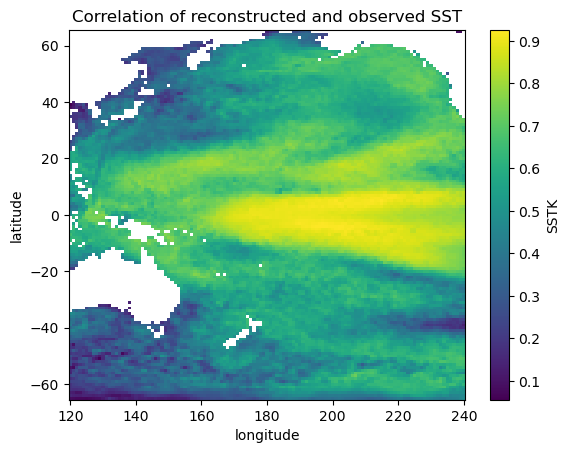

In [52]:
#plotting the correlation between reconstructed and observed SST time series
correlation.plot()
plt.title('Correlation of reconstructed and observed SST')

# Part 6

To find the correlation between SST EOF1 and monthly mean detrended, deseasonalized and standardized monthly mean precipitation anomalies we will use the total precipitation dataset that been detrended, deseasonalized and standardized along with the SST values in part 1

In [53]:
#computing the correlation between the detrended, deseasonalized and 
#standardized precip values and the first principal componate of SST.

ds_corr = xr.corr(ds_standard.TP, eof[0], dim = 'time')

c:\Users\Charu\miniconda3\envs\py3-swn\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Charu\miniconda3\envs\py3-swn\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 1.0, 'Correlation of Precipitation and first PC of SST')

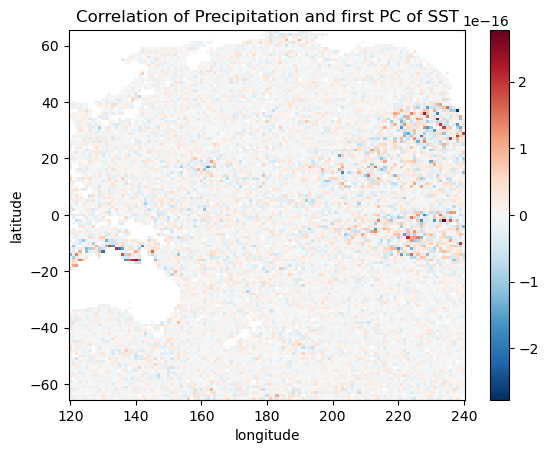

In [54]:
#plottig the correlation between the detrended, deseasonalized and 
#standardized precip values and the first principal componate of SST.

ds_corr.plot()
plt.title('Correlation of Precipitation and first PC of SST')

In [55]:
#computing the correlation between the detrended, deseasonalized and 
#standardized precip values and the reconstructed SST field.

ds_correlation = xr.corr(ds_standard.TP, ds_restructed, dim = 'time')

c:\Users\Charu\miniconda3\envs\py3-swn\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Charu\miniconda3\envs\py3-swn\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 1.0, 'Correlation of Precipitation and reconstruced SSTK')

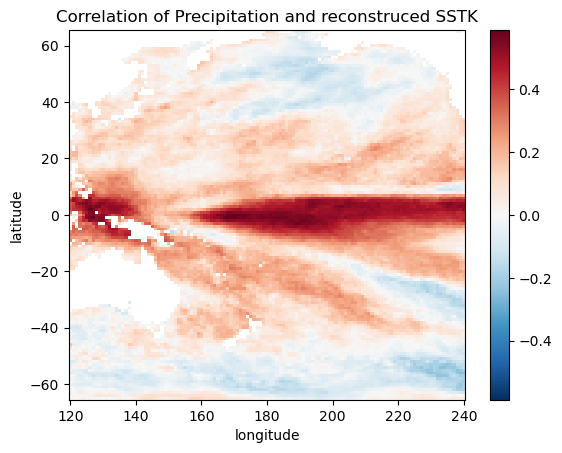

In [56]:
#computing the correlation between the detrended, deseasonalized and 
#standardized precip values and the reconstructed SST field.

ds_correlation.plot()
plt.title('Correlation of Precipitation and reconstruced SSTK')

In [ ]:
client.close()